In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina'

import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager.findfont(font)

'/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'

In [2]:
!pip install mecab-python3

In [3]:
import tensorflow as tf
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

import MeCab

import time
import re
import os
import io
from tqdm import tqdm
import random

from utils import *
from models import Encoder, Decoder
from loss import loss_function

In [4]:
# GPU가 사용 가능한 경우, 기본 디바이스를 GPU로 설정
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.set_visible_devices(gpus[0], 'GPU')  # 첫 번째 GPU만 사용
        tf.config.experimental.set_memory_growth(gpus[0], True)  # 필요할 때만 GPU 메모리 사용
    except RuntimeError as e:
        print(e)

print("✅ GPU 활성화됨:", tf.config.list_physical_devices('GPU'))

✅ GPU 활성화됨: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### 데이터 다운로드

In [5]:
path_to_dir = os.getenv('HOME') + "/aiffel/s2s_translation/data/"

path_to_train_kor = path_to_dir + "korean-english-park.train.ko"
path_to_train_eng = path_to_dir + "korean-english-park.train.en"

path_to_test_kor = path_to_dir + "korean-english-park.test.ko"
path_to_test_eng = path_to_dir + "korean-english-park.test.en"

In [6]:
src_train = read_data(path_to_train_kor)
tgt_train = read_data(path_to_train_eng)

src_test = read_data(path_to_test_kor)
tgt_test = read_data(path_to_test_eng)

In [7]:
print(len(src_train))
print(len(src_test))

94123
2000


In [8]:
# 데이터 중복 제거
unique_pairs = set(zip(src_train, tgt_train))
corpus_train = list(unique_pairs)

print(len(corpus_train))

78968


### 데이터 전처리

In [9]:
enc_corpus_train = []
dec_corpus_train = []

for pair in corpus_train:
    kor, eng = pair[0], pair[1]
    kor_preprocessed = preprocess_kor(kor)
    eng_preprocessed = preprocess_eng(eng)
    
    # 전처리 후 샘플에 단어가 없을 경우는 append x
    if len(kor_preprocessed) != 0 and len(eng_preprocessed) > 2:
        enc_corpus_train.append(kor_preprocessed)
        dec_corpus_train.append(eng_preprocessed)

In [10]:
print("Korean:", enc_corpus_train[1972])
print("English:", dec_corpus_train[1972])

print(len(enc_corpus_train))
print(len(dec_corpus_train))

Korean: 지난 num월 탁신 총리가 해외에 나가 있는 동안 군부가 쿠데타를 일으켜 탁신 총리와 합법적 선거를 통해 구성된 정부를 전복시킨 이후 태국은 정치적 혼란 상황에 빠져 있었다
English: <start> thailand has been in political turmoil since the military led a coup against thaksin and his legally elected government while he was out of the country last september <end>
78891
78891


In [12]:
# 토큰화하기
enc_input_tok, enc_tokenizer = tokenize_kor(enc_corpus_train)
dec_input_tok, dec_tokenizer = tokenize_eng(dec_corpus_train)

In [13]:
max_len = 50

enc_input = []
dec_input = []

for enc, dec in zip(enc_input_tok, dec_input_tok):
    if len(enc) <= max_len and len(dec) <= max_len:
        enc_input.append(enc)
        dec_input.append(dec)

In [14]:
enc_input = tf.keras.preprocessing.sequence.pad_sequences(enc_input, 
                                                          maxlen=max_len,
                                                          padding='post')
dec_input = tf.keras.preprocessing.sequence.pad_sequences(dec_input, 
                                                        maxlen=max_len,
                                                        padding='post')

In [15]:
# train_test_split을 활용해서 훈련 데이터와 검증 데이터로 분리하기
enc_train, enc_val = train_test_split(enc_input, test_size=0.2)
dec_train, dec_val = train_test_split(dec_input, test_size=0.2)

### 모델 설계

In [16]:
BATCH_SIZE = 256
SRC_VOCAB_SIZE = len(enc_tokenizer.index_word) + 1
TGT_VOCAB_SIZE = len(dec_tokenizer.index_word) + 1

units = 512
embedding_dim = 512

encoder = Encoder(SRC_VOCAB_SIZE, embedding_dim, units, num_layers=2)
decoder = Decoder(TGT_VOCAB_SIZE, embedding_dim, units, num_layers=2)

# sample input
sequence_len = max_len

sample_enc = tf.random.uniform((BATCH_SIZE, sequence_len))
sample_output = encoder(sample_enc)

print ('Encoder Output:', sample_output.shape)

sample_state = tf.random.uniform((BATCH_SIZE, units))

sample_logits, h_dec, attn = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                     sample_state, sample_output)

print ('Decoder Output:', sample_logits.shape)
print ('Decoder Hidden State:', h_dec.shape)
print ('Attention:', attn.shape)

Encoder Output: (256, 50, 512)
Decoder Output: (256, 1, 44598)
Decoder Hidden State: (256, 512)
Attention: (256, 50, 1)


### 학습 & 추론

In [21]:
optimizer = tf.keras.optimizers.Adam(0.0002)

In [22]:
@tf.function
def train_step(src, tgt, encoder, decoder, optimizer, dec_tok):
    batch_size = src.shape[0]
    loss = 0

    with tf.GradientTape() as tape:
        enc_out = encoder(src)
        h_dec = enc_out[:, -1]
        
        dec_src = tf.expand_dims([dec_tok.word_index['<start>']] * batch_size, 1)

        for t in range(1, tgt.shape[1]):
            pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)

            loss += loss_function(tgt[:, t], pred)
            dec_src = tf.expand_dims(tgt[:, t], 1)
        
    batch_loss = (loss / int(tgt.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    
    return batch_loss

In [23]:
# Define eval_step
@tf.function
def eval_step(src, tgt, encoder, decoder, dec_tok):
    bsz = src.shape[0]
    loss = 0

    enc_out = encoder(src)

    h_dec = enc_out[:, -1]
    
    dec_src = tf.expand_dims([dec_tok.word_index['<start>']] * bsz, 1)

    for t in range(1, tgt.shape[1]):
        pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)

        loss += loss_function(tgt[:, t], pred)
        dec_src = tf.expand_dims(tgt[:, t], 1)
        
    batch_loss = (loss / int(tgt.shape[1]))
    
    return batch_loss


# Training Process with validation

EPOCHS = 15

for epoch in range(EPOCHS):
    total_loss = 0
    
    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)

    for (batch, idx) in enumerate(t):
        batch_loss = train_step(enc_train[idx:idx+BATCH_SIZE],
                                dec_train[idx:idx+BATCH_SIZE],
                                encoder,
                                decoder,
                                optimizer,
                                dec_tokenizer)
    
        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))
    
    test_loss = 0
    
    idx_list = list(range(0, enc_val.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)

    for (test_batch, idx) in enumerate(t):
        test_batch_loss = eval_step(enc_val[idx:idx+BATCH_SIZE],
                                    dec_val[idx:idx+BATCH_SIZE],
                                    encoder,
                                    decoder,
                                    dec_tokenizer)
    
        test_loss += test_batch_loss

        t.set_description_str('Test Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Test Loss %.4f' % (test_loss.numpy() / (test_batch + 1)))

Test Epoch 15: 100%|██████████| 60/60 [00:30<00:00,  1.95it/s, Test Loss 2.1202]


### 번역 결과 확인

Input: ['토론', '에', '참여', '한', '사람', '들', '은', '법', '집행', '과', '국가', '안전', '보장', '에', '대한', '우려', '를', '표명', '해야', '할', '필요', '성', '을', '진지', '하', '게', '받', '아', '들', '이', '고', '있', '습니다', 'EOS']
Predicted translation: the num than num than num than num than num than num than num than num than num than num than num than num than num than num than num than num than num than num than num than num than num than num than num than num than num 


/tmp/ipykernel_146/3390980278.py:61: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_146/3390980278.py:63: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


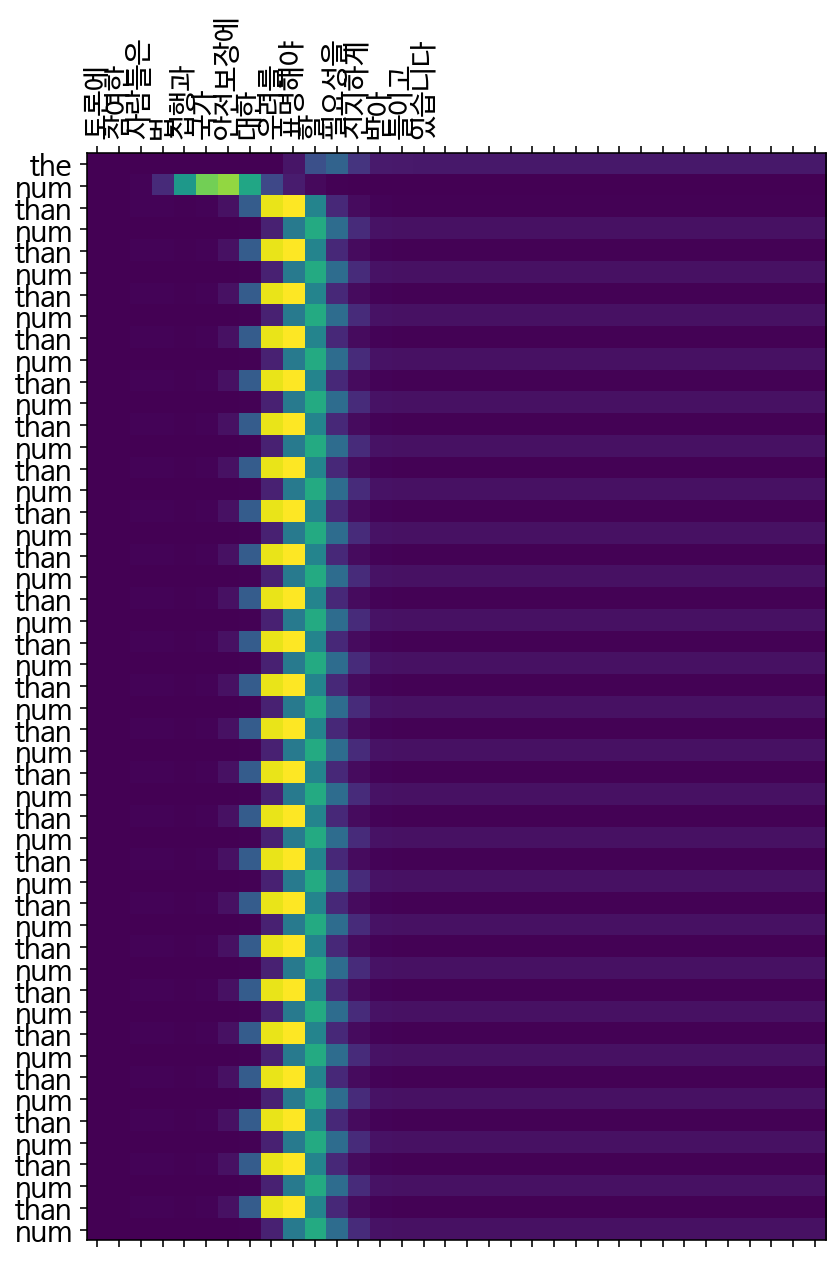

Input: ['또한', '새로운', '기술', '개발', '이', '어떤', '해결책', '을', '제공', '해', '주', '는데', '도움', '이', '될', '것', '이', '고', '동시', '에', '통신망', '사용', '자', '들', '이', '보다', '안', '전하', '게', '통신', '을', '할', '수', '있', '도록', '도움', '을', '주', '게', '되', '리라는', '희망', '도', '있', '습니다', 'EOS']
Predicted translation: the num than num than num than num than num than num than num than num than num than num than num than num than num than num than num than num than num than num than num than num than num than num than num than num than num 


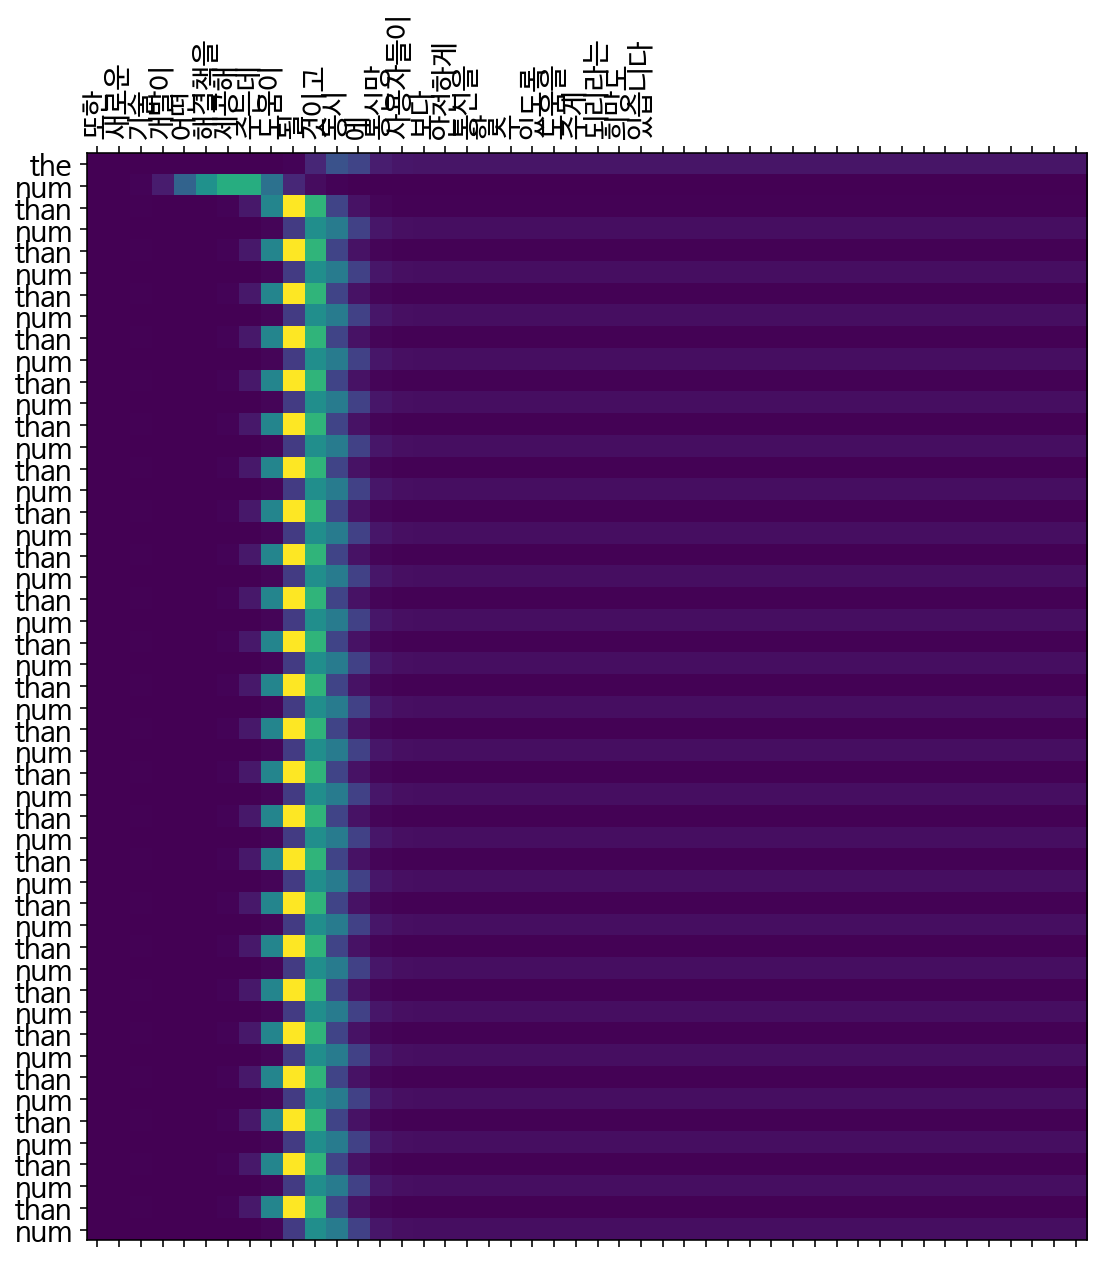

Input: ['그래서', '클리퍼', '칩', '에', '대한', '개인', '적', '인', '해결책', '은', '서서히', '자취', '를', '감출', '것', '입니다', '그러나', '이', '문제', '는', '계속', '우리', '곁', '에', '존재', '할', '것', '이', '며', '당분간', '은', '심각', '한', '상태', '로', '존재', '할', '것', '입니다', 'EOS']
Predicted translation: the num than num than num than num than num than num than num than num than num than num than num than num than num than num than num than num than num than num than num than num than num than num than num than num than num 


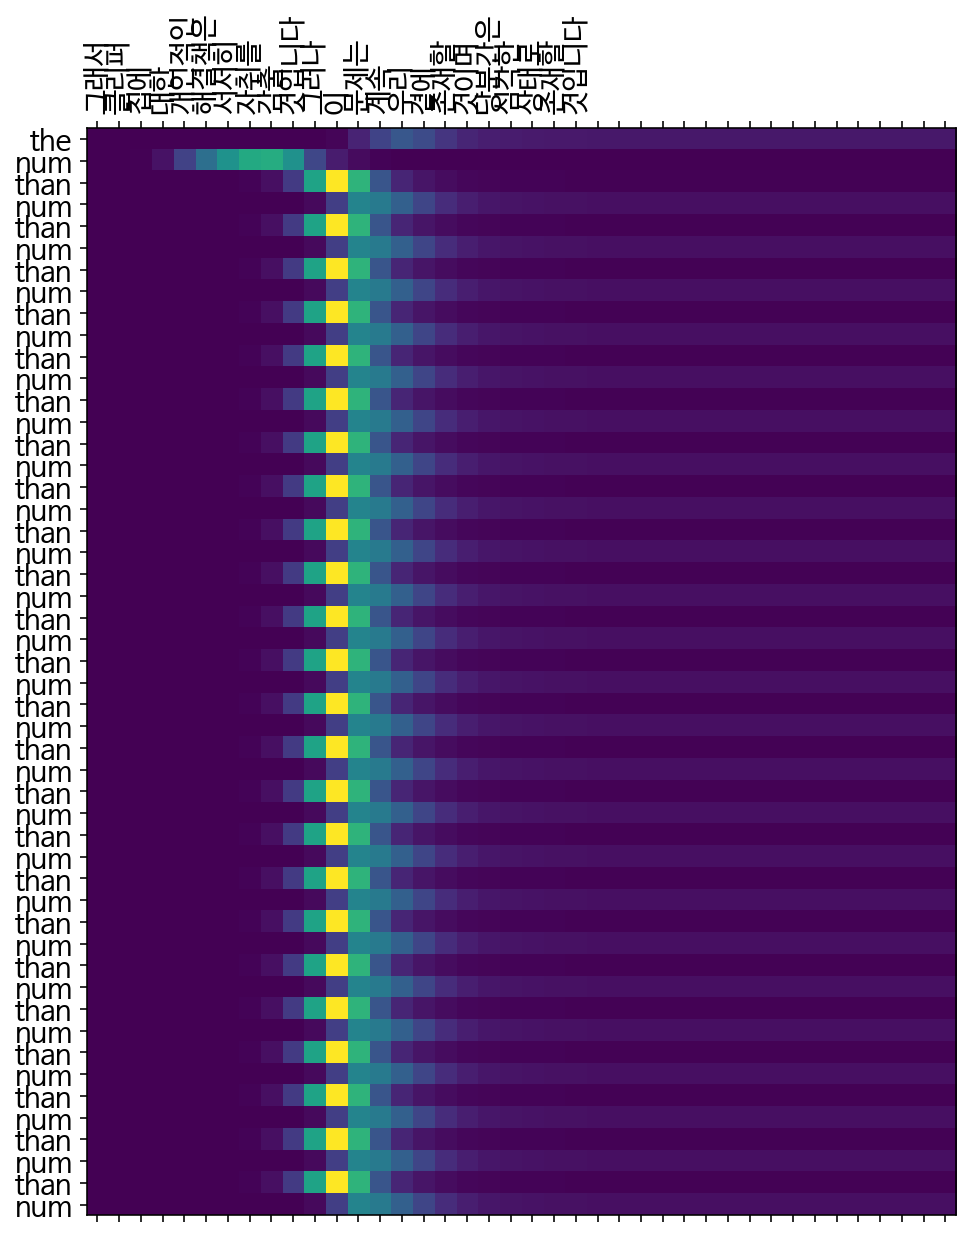

Input: ['이탈리아', '의', '천문학자', '들', '이', '멀리', '에', '있', '는', '별', '들', '의', '궤도', '를', '도', '는', '행성', '의', '대기', '에서', '생명체', '의', '필수', '요소', '인', '물', '이', '존재', '한다는', '징후', '를', '발견', '했', '다', 'EOS']
Predicted translation: the num than num than num than num than num than num than num than num than num than num than num than num than num than num than num than num than num than num than num than num than num than num than num than num than num 


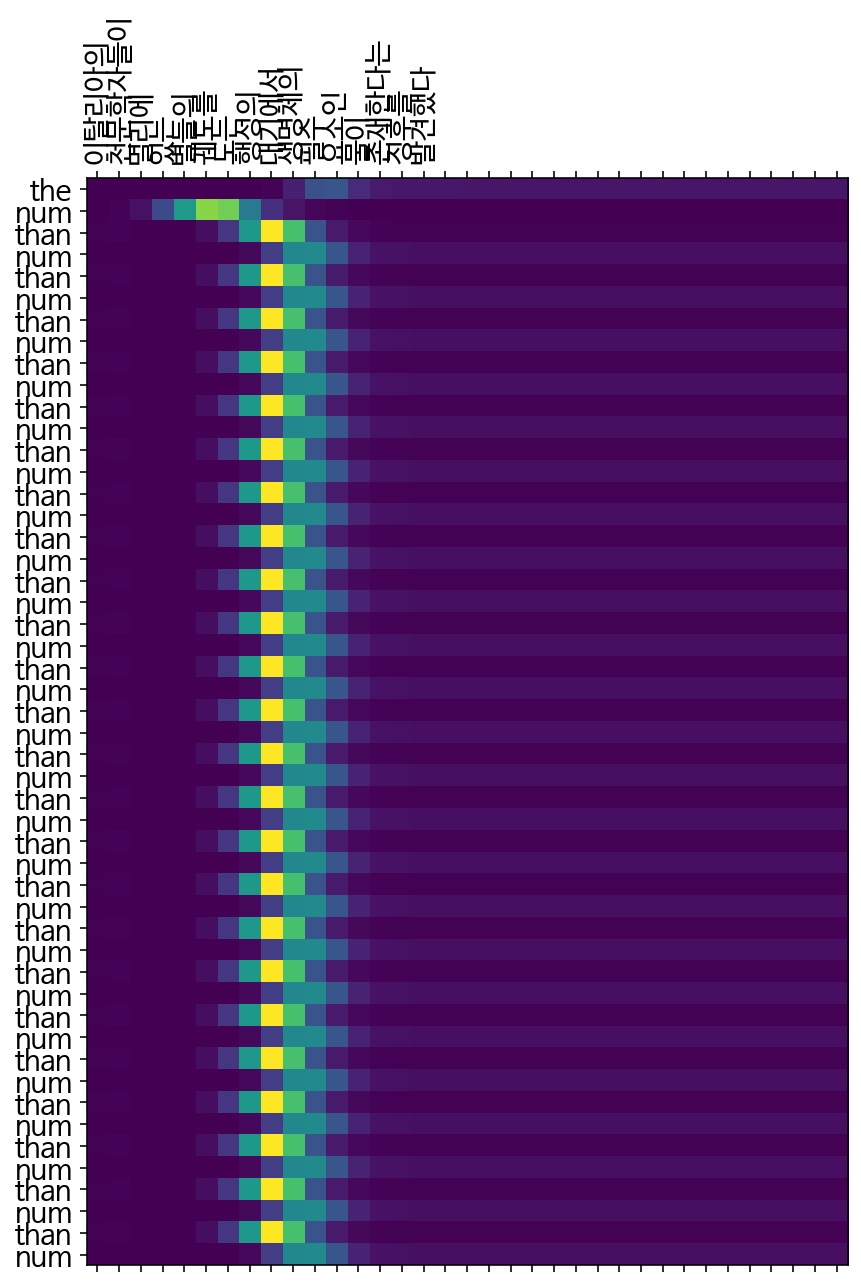

Input: ['물', '이', '있', '다는', '것', '이', '다른', '행성', '에', '생명체', '들', '이', '가득', '하', '다는', '것', '을', '의미', '하', '지', '는', '않', '지만', '이번', '발견', '이', '확인', '된다면', '그런', '일', '이', '가능', '할', '수', '있', '다는', '추측', '을', '증폭', '시키', '게', '될', '것', '이', '다', 'EOS']
Predicted translation: the num year in the num year in the num year in the num year in the num year in the num year in the num year in the num year in the num year in the num year in the num year in the num year in the num 


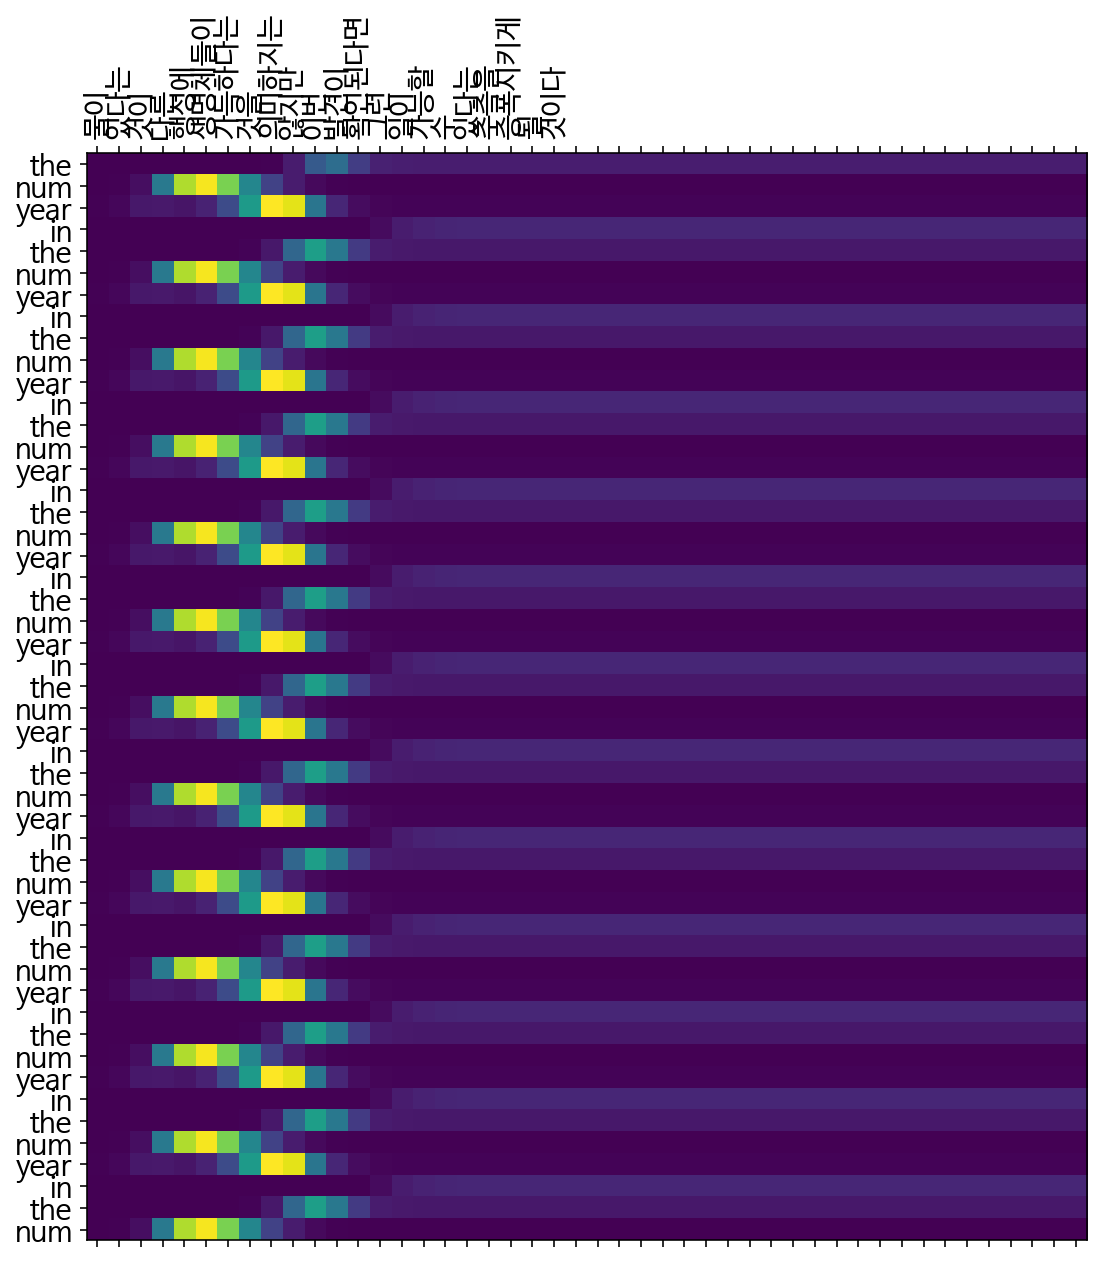

Input: ['그', '들', '은', '수분', '에서', '방출', '되', '는', '전자파', '를', '찾', '기', '위해', 'num', '미터', '짜리', '전파', '망원경', '을', '사용', '했', '는데', '이', '는', '이', '전자파', '가', '그', '별', '의', '적외선', '에', '포함', '되', '어', '있', '게', '되', '면', '행성', '의', '대기', '에', '물', '이', '있', '다는', '것', '을', '나타내', '주', '게', '되', '는', '예고', '적', '성격', '의', '극초단파', '이', '다', 'EOS']
Predicted translation: the num than num than num than num than num than num than num than num than num than num than num than num than num than num than num than num than num than num than num than num than num than num than num than num than num 


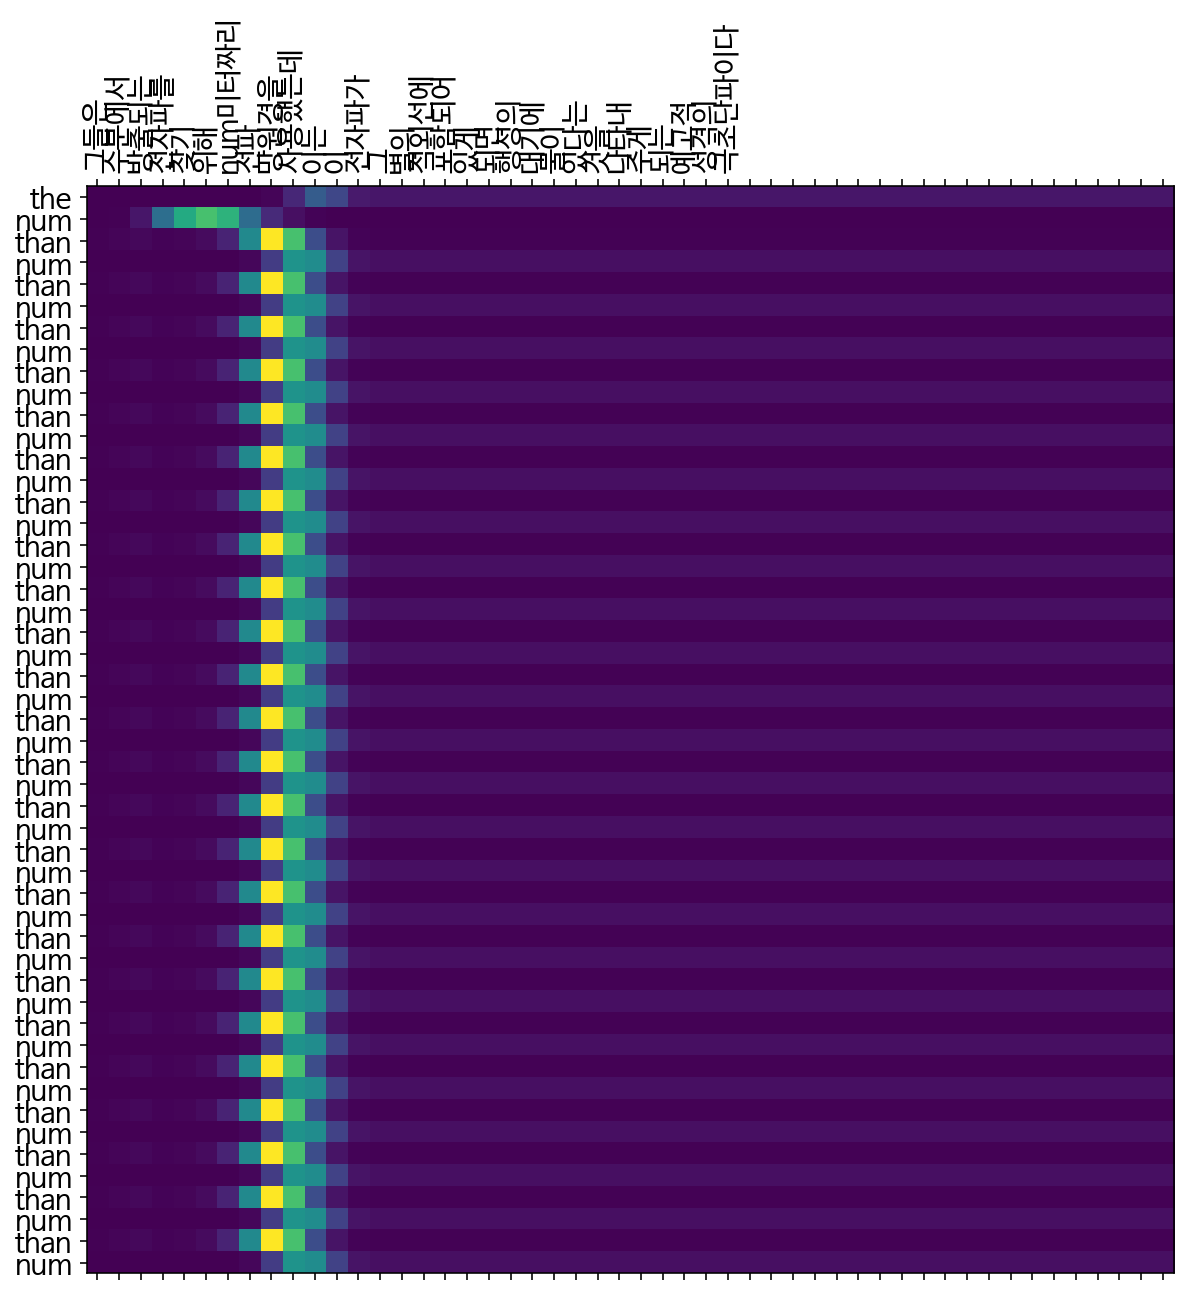

Input: ['num', '마리', '의', '전갈', '과', 'num', '일', '동안', '동거', '할', '태국', '여인', '전갈', 'num', '마리', '가', '모두', '당신', '의', '방', '에', '있', '다면', '그것', '은', '악몽', '일', '것', '이', '다', 'EOS']
Predicted translation: the num than num than num than num than num than num than num than num than num than num than num than num than num than num than num than num than num than num than num than num than num than num than num than num than num 


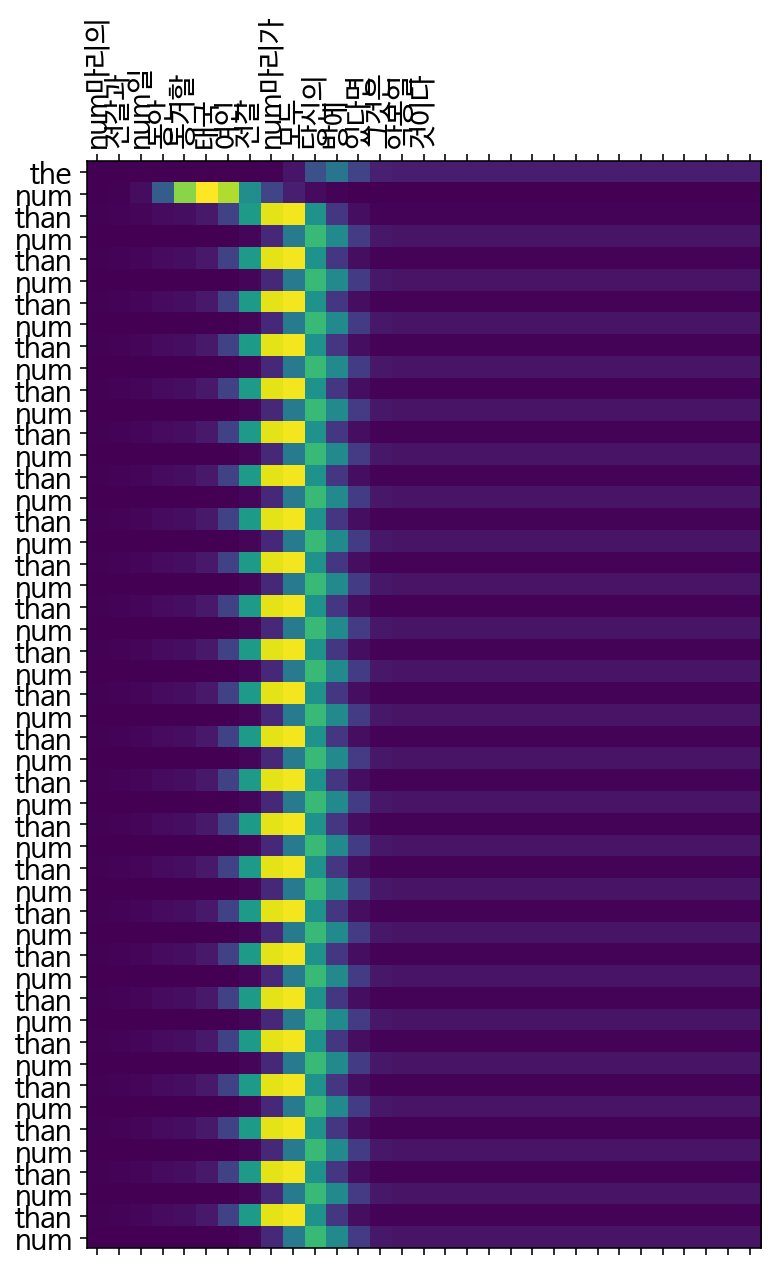

Input: ['전갈', '로', '가득', '찬', '방', '에서', '가장', '오래', '머물러', '있', '기', '에', '대한', '세계', '기록', '을', '깨', '고', '싶', '어', '하', '는', 'num', '세', '의', '태국', '여인', '칸', '차', '나', '케트', '키우', '는', '앞', '으로', 'num', '일', '동안', '맹독', '을', '지닌', '동거자', '들', '과', '함께', '잠', '을', '잘', '때', '에', '잠들', '지', '못하', '는', '일', '은', '없', '을', '것', '이', '라고', '자신', '한다', 'EOS']
Predicted translation: the num year in the num year in the num year in the num year in the num year in the num year in the num year in the num year in the num year in the num year in the num year in the num year in the num 


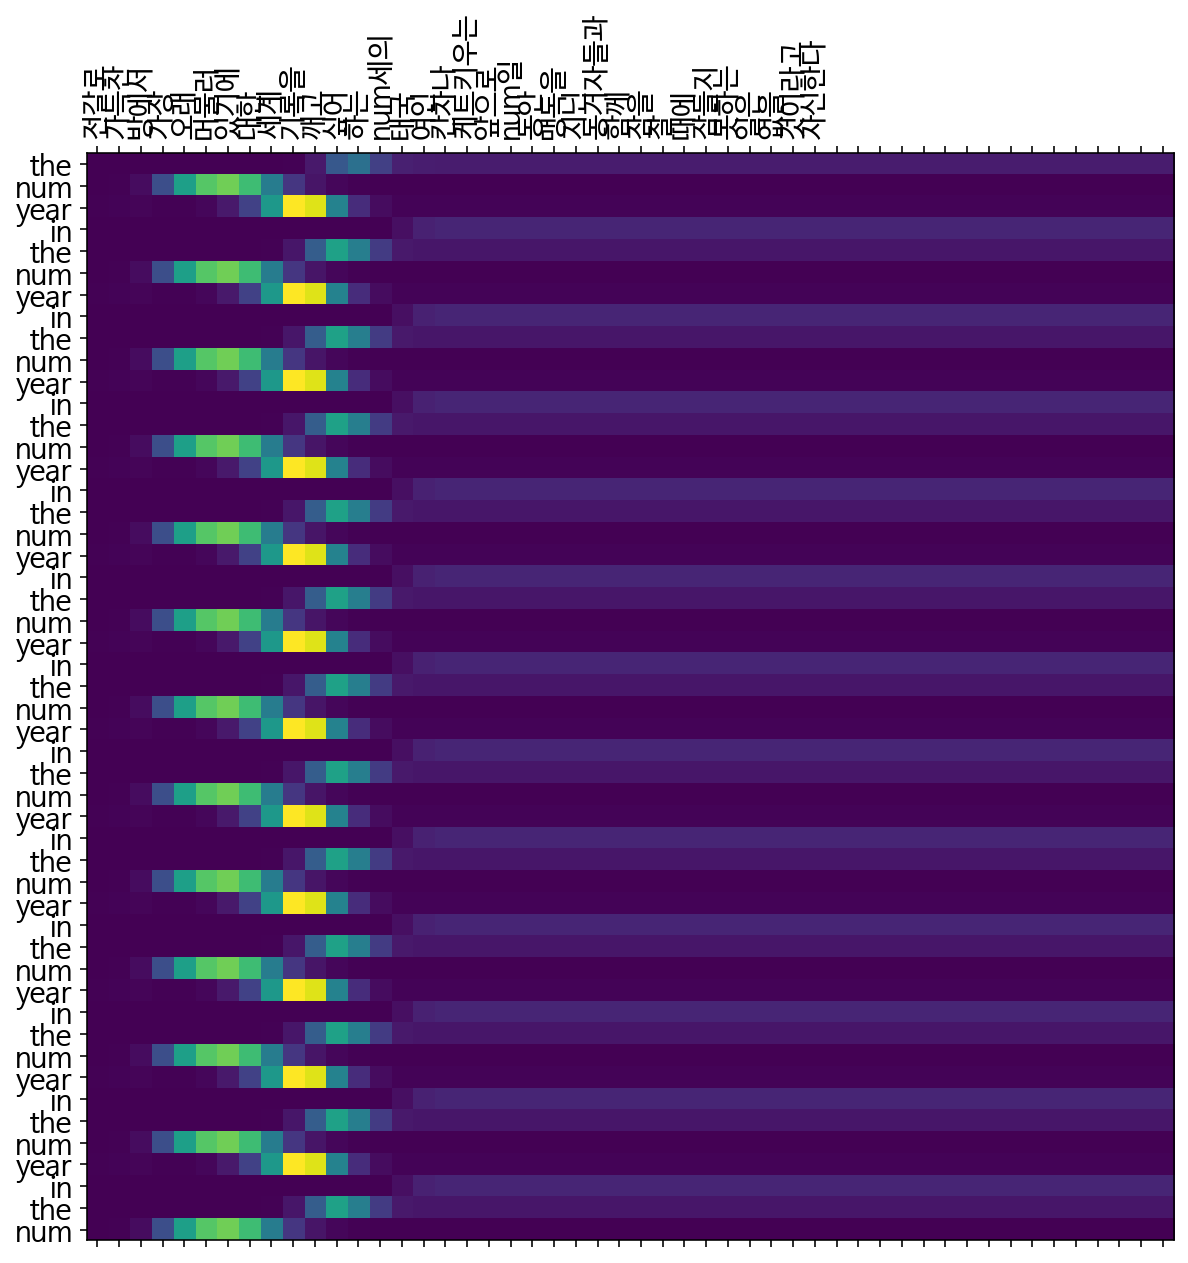

Input: ['석유', '거래', '상', '들', '이', '고조', '되', '고', '있', '는', '미국', '의', '이라크', '공격', '가능', '성', '을', '고려', '함', '에', '따라', '전쟁', '열기', '가', '미국', '의', '유가', '를', 'num', '개월', '만', '에', '최고', '치', '로', '밀', '어', '올렸', '다', 'EOS']
Predicted translation: the num than num than num than num than num than num than num than num than num than num than num than num than num than num than num than num than num than num than num than num than num than num than num than num than num 


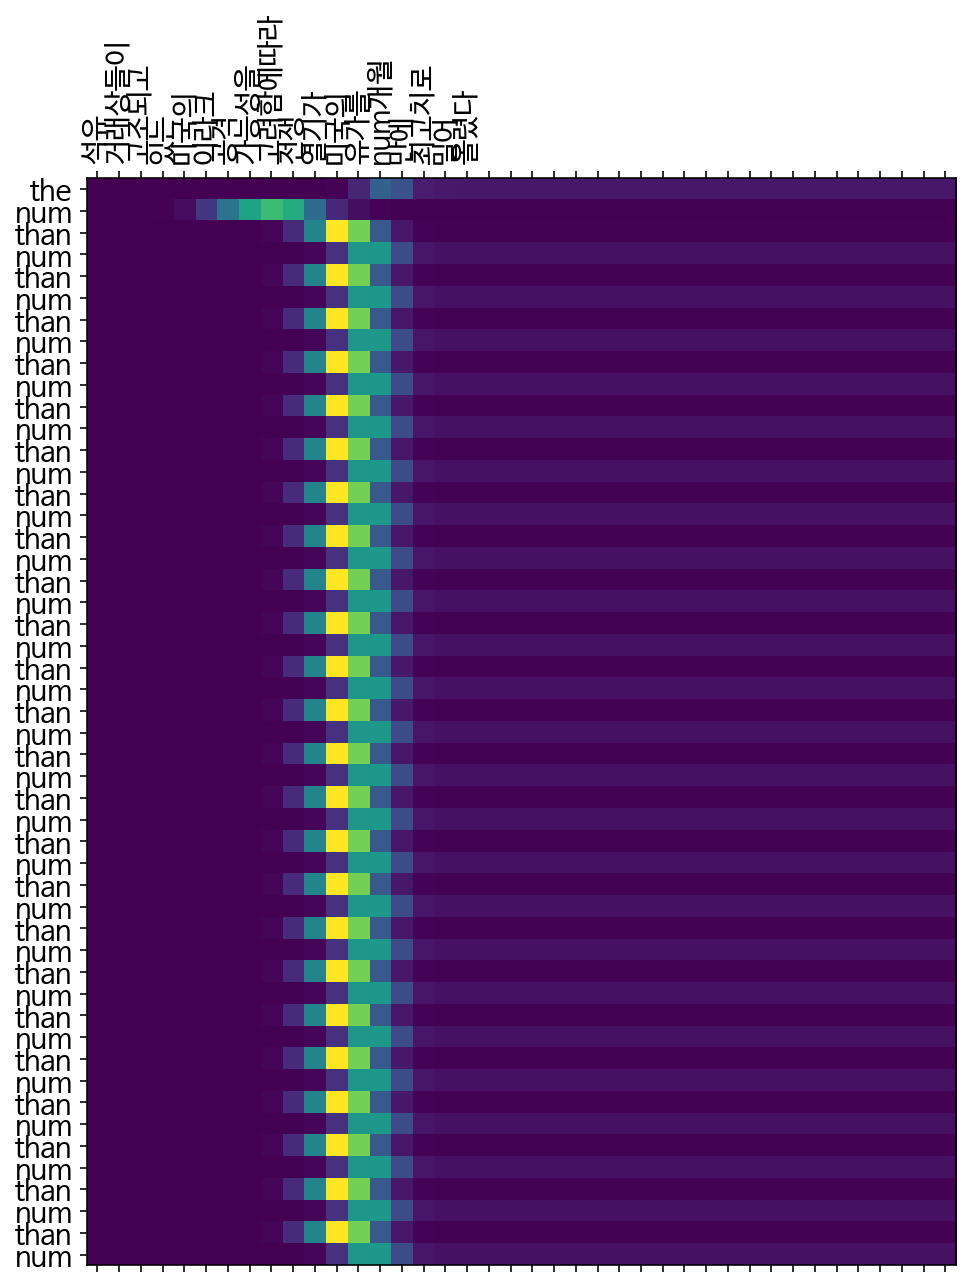

Input: ['전자', '거래', '에서', '미국', '의', '원유', '선물', '가격', '이', '배럴', '당', 'num', '달러', '로', '최고', '치', '를', '기록', '한', '이후', '에', 'num', '달러', '로', 'num', '센트', '급등', '했', '다', 'EOS']
Predicted translation: the num than num than num than num than num than num than num than num than num than num than num than num than num than num than num than num than num than num than num than num than num than num than num than num than num 


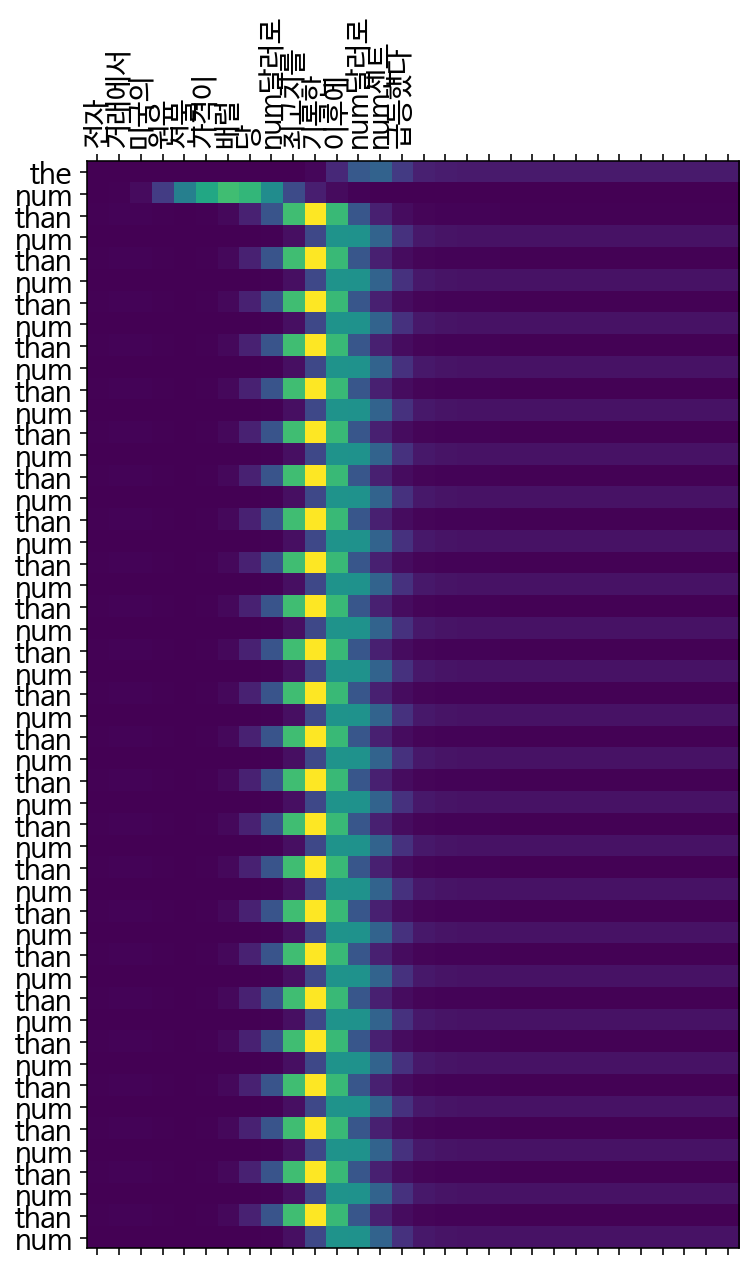

In [27]:
def mecab_tokenize(sentence):
    mecab = MeCab.Tagger()
    # MeCab으로 토큰화한 결과를 공백으로 구분된 단어 리스트로 변환
    tokens = mecab.parse(sentence).splitlines()
    tokens = [token.split('\t')[0] for token in tokens if token != '']
    return tokens

def evaluate(sentence, encoder, decoder):
    attention = np.zeros((dec_train.shape[-1], enc_train.shape[-1]))
    
    # 한글 전처리 적용
    sentence = preprocess_kor(sentence)
    
    # MeCab으로 토큰화
    sentence_tokens = mecab_tokenize(sentence)
    
    # 토큰화된 문장을 숫자 시퀀스로 변환
    inputs = enc_tokenizer.texts_to_sequences([sentence_tokens])
    inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs,
                                                           maxlen=enc_train.shape[-1],
                                                           padding='post')
    
    result = ''

    # 인코더 처리
    enc_out = encoder(inputs)

    # 디코더 초기 상태 설정
    dec_hidden = enc_out[:, -1]
    dec_input = tf.expand_dims([dec_tokenizer.word_index['<start>']], 0)

    for t in range(dec_train.shape[-1]):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        attention_weights = tf.reshape(attention_weights, (-1,))
        attention[t] = attention_weights.numpy()

        # 예측된 단어를 선택
        predicted_id = tf.argmax(tf.math.softmax(predictions, axis=-1)[0], axis=-1).numpy()  # Shape: (batch_size,)
        predicted_id = predicted_id[0]

        result += dec_tokenizer.index_word[predicted_id] + ' '

        if dec_tokenizer.index_word[predicted_id] == '<end>':
            return result, sentence, attention

        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention


def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def translate(sentence, encoder, decoder):
    result, sentence, attention = evaluate(sentence, encoder, decoder)
    
    morphs = mecab_tokenize(sentence)
    print('Input: %s' % (morphs))
    print('Predicted translation: {}'.format(result))
    
    attention = attention[:len(result.split()), :len(morphs)]
    plot_attention(attention, sentence.split(), result.split(' '))


for text in src_test[0:10]:
    translate(text, encoder, decoder)

#### 수정사항

##### 1) 데이터 전처리

1. 중복 제거를 어떻게 할까?
    - 기존의 방식 : source, target 둘 다 겹치면 중복으로 간주  
    - 대안 : source만 겹쳐도 중복으로 간주
        - 같은 source, 다른 target을 가진 pair들 중에 무엇을 선택할 것인지에 대한 문제가 있음.
        - 중복 데이터가 많아져 데이터 수가 기존 방식에 비해 줄어듦
        - 오히려 같은 한국어 문장이 다양하게 번역될 수 있다는 점을 학습시킬 수 없어 모델이 표현 다양성을 학습하는 데 제한이 생길 수 있음.
    
**=> source, target 둘 다 겹치면 중복처리하는 기존 방식 유지**  

2. 전처리 함수
    - source & target dataset EDA
    - 일부 특수기호를 단어로 변경
    - 숫자를 살리는 대신, ',', '.', 괄호 안 단어 등을 추가로 제거  
    
3. 토큰화 -> 문장 길이 제한으로 순서 변경


##### 2) 모델 설계

1. Encoder & Decoder
    - gru layer를 여러 개 쌓는 로직 추가
    - 어텐션은 decoder의 마지막 layer에만 적용

#### 개선'할' 점

##### 1) 모델 설계

1. Attention module
    - Luong attention 구현해보고 Bahdanau와 성능 비교
 

##### 2) 훈련 & 추론

1. hyperparameter tuning
    - embedding_dim
    - num_units
    - batch_size
    - learning_rate

2. callback 추가
    - checkpoint
    - early stopping
    
##### 3) etc

1. 한국어 텍스트의 한자를 한국어 단어로 변환하는 로직을 전처리 함수에 추가

### 회고

전처리 함수 수정, 모델 configuration 등을 수행한 결과 loss 자체는 줄었지만 정성적 관점에서 봤을 때 성능이 매우 좋지 않았다. 아마 num 토큰이 전처리 과정에서 너무 많이 나와 토큰 간 불균형이 더 커진 결과로 보인다. 다음 퀘스트에서 숫자나 한자 등을 어떻게 처리할 지에 대해 더 고민해봐야겠다.